<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/park.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 公園

In [ ]:
!pip install -q geocoder
!pip install -q --upgrade xlrd
!pip install -q japanize-matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [ ]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse
import geocoder
import math
import io
import re
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [ ]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

def number_to_kanji(str):
    return str.translate(str.maketrans({
        '１':'一', '２':'二', '３':'三', '４':'四', '５':'五', '６':'六', '７':'七', '８':'八', '９':'九',
        '1':'一', '2':'二', '3':'三', '4':'四', '5':'五', '6':'六', '7':'七', '8':'八', '9':'九', '0':'十', 
    }))

# 緯度経度取得
def add_lat_lon(df_master):
    lats = []
    lons = []
    for i, row in df_master.iterrows():
        chocho = number_to_kanji(row['町丁目'])
        ret = geocoder.osm('東京都' + row['市区町村名'] + chocho, timeout=5)
        if not ret.ok:
            print(i, row['市区町村名'], chocho)
        lats.append(ret.lat)
        lons.append(ret.lng)
    df_copy = df_master.copy()
    df_copy['緯度'] = lats
    df_copy['経度'] = lons
    return df_copy

# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [ ]:
def get_tokyo_ward_city(address):
    _tmp = address.replace('東京都', '')
    m = re.search('^.*?[区市]', _tmp)
    cityname = m.group()
    return cityname if len(cityname) < 6 else None

def get_category_facility(name):
    if re.search('.*公園$', name) is not None:
        return '公園'
    if re.search('.*緑地$', name) is not None:
        return '公園'
    if re.search('.*緑道$', name) is not None:
        return '公園'
    if re.search('.*庭園$', name) is not None:
        return '公園'
    if re.search('.*図書館$', name) is not None:
        return '図書館'
    if re.search('.*美術館$', name) is not None:
        return '文化施設'
    if re.search('.*博物館$', name) is not None:
        return '文化施設'
    if re.search('.*会館$', name) is not None:
        return '文化施設'
    if re.search('.*劇場$', name) is not None:
        return '文化施設'
    if re.search('アーツ', name) is not None:
        return '文化施設'
    if re.search('.*園$', name) is not None:
        return '公園'
    return None

In [ ]:
def change_type(df_data):
    df_data['緯度'] = df_data['緯度'].astype(float)
    df_data['経度'] = df_data['経度'].astype(float)

In [ ]:
extract_columns = ['施設分類', '施設名', '市区町村名', '所在地', '緯度', '経度']

## 0. 東京都
- [公共施設一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t000003d0000000033/resource/27d1ce20-9023-4690-944c-5da47ed1427e)

In [ ]:
tokyo_public_facility = 'https://www.opendata.metro.tokyo.lg.jp/suisyoudataset/130001_public_facility.csv'
df_tokyo_public_facility = get_data_csv_url(tokyo_public_facility, encoding='cp932')
print(df_tokyo_public_facility.shape)

df_tokyo_public_facility = df_tokyo_public_facility.rename(columns={'名称':'施設名', '住所': '所在地'})
df_tokyo_public_facility['市区町村名'] = df_tokyo_public_facility['所在地'].apply(get_tokyo_ward_city)
df_tokyo_public_facility['施設分類'] = df_tokyo_public_facility['施設名'].apply(get_category_facility)
df_tokyo_public_facility = df_tokyo_public_facility[extract_columns]
df_tokyo_public_facility = df_tokyo_public_facility[
    (df_tokyo_public_facility['施設分類'].notna())&
    (df_tokyo_public_facility['市区町村名'].str.endswith('区'))
].reset_index(drop=True)
change_type(df_tokyo_public_facility)
print(df_tokyo_public_facility.shape)

(136, 39)
(95, 6)


## 1. 千代田区

## 2. 中央区
- [区内の公園一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131024d0000000011/resource/2cebf9bb-c082-41a4-973f-f39e81c20aa2)

## 3. 港区
- [公園・児童遊園・緑地](https://catalog.data.metro.tokyo.lg.jp/dataset/t131032d0000000014/resource/07c70d2b-0474-491c-a1f4-754b8f28922b)

In [ ]:
minato_park_url = 'https://opendata.city.minato.tokyo.jp/dataset/dc609dcf-892a-4a20-8f74-f62ce9fc806d/resource/f636e5b8-088f-42e2-b95c-d0978d4e339c/download/minatokushisetsujoho_kouen.csv'
df_minato_park = get_data_csv_url(minato_park_url)
print(df_minato_park.shape)

df_minato_park['市区町村名'] = '港区'
df_minato_park['施設分類'] = '公園'
df_minato_park = df_minato_park[df_minato_park['第1分類'] == '公園・児童遊園・緑地'].reset_index(drop=False)
df_minato_park = df_minato_park.rename(columns={'ページタイトル':'施設名'})[extract_columns]
change_type(df_minato_park)
print(df_minato_park.shape)

(157, 31)
(156, 6)


## 4. 新宿区

## 5. 文京区
- [区立公園・児童遊園・遊び場一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131059d0509040001/resource/81688b74-8b82-4529-a1df-1d0ae73a808d)

## 6. 台東区
- [公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131067d0000000093/resource/c70f81da-7c29-497a-ab55-068686d75707)
- [児童遊園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131067d0000000094/resource/5d61c7a3-573d-4a27-8492-6e299f2fe401)

In [ ]:
taito_park_url_1 = 'https://www.city.taito.lg.jp/kusei/online/opendata/seikatu/shisethutizujouhou.files/sisetu_15.csv'
df_taito_park_1 = get_data_csv_url(taito_park_url_1, 'shift-jis')
taito_park_url_2 = 'https://www.city.taito.lg.jp/kusei/online/opendata/seikatu/shisethutizujouhou.files/sisetu_16.csv'
df_taito_park_2 = get_data_csv_url(taito_park_url_2, 'shift-jis')
df_taito_park = pd.concat([df_taito_park_1, df_taito_park_2]).reset_index(drop=True)
print(df_taito_park.shape)

df_taito_park['市区町村名'] = '台東区'
df_taito_park['施設分類'] = '公園'
df_taito_park = df_taito_park.rename(columns={'名称':'施設名', 'X座標':'経度', 'Y座標':'緯度'})[extract_columns]
print(df_taito_park.shape)

(83, 8)
(83, 6)


## 7. 墨田区
- [公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131075d0000000097/resource/ea22e8d7-677a-4ab8-b231-f5d309fd0be6)
- [児童遊園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131075d0000000097/resource/21a0e89e-ee2f-4bf0-90db-b70ebb77453e)

In [ ]:
sumida_park_url_1 = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/park.csv'
df_sumida_park_1 = get_data_csv_url(sumida_park_url_1, 'shift-jis')
sumida_park_url_2 = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/jidouyuuen.csv'
df_sumida_park_2 = get_data_csv_url(sumida_park_url_2, 'shift-jis')
df_sumida_park = pd.concat([df_sumida_park_1, df_sumida_park_2]).reset_index(drop=True)
print(df_sumida_park.shape)

df_sumida_park['市区町村名'] = '墨田区'
df_sumida_park['施設分類'] = '公園'
df_sumida_park = df_sumida_park.rename(columns={'施設名称':'施設名'})[extract_columns]
print(df_sumida_park.shape)

(144, 5)
(144, 6)


## 8. 江東区
- [区立公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131083d0000000007/resource/204f8626-3307-48e3-9d2c-03d38aa732f1)
- [児童遊園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131083d0000000007/resource/cef3a8af-0006-4341-a0ab-a62b26a5a28c)

## 9. 品川区
- [公園・緑地・防災活動広場](https://catalog.data.metro.tokyo.lg.jp/dataset/t131091d0000000130)

## 10. 目黒区
- [区立公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131105d0000000038/resource/1264013c-5458-409e-95be-208f0d78d51b)

In [ ]:
megro_park_url = 'https://data.bodik.jp/dataset/9f7d70e4-d41f-4199-a180-eb2e3de6e728/resource/28badfb6-f33f-4b12-8ecc-ada279950cee/download/131105_park_20210401.csv'
df_megro_park = get_data_csv_url(megro_park_url, 'cp932')
print(df_megro_park.shape)

df_megro_park['市区町村名'] = '目黒区'
df_megro_park['施設分類'] = '公園'
df_megro_park = df_megro_park[df_megro_park['面積（㎡）'] >= 500]
df_megro_park = df_megro_park.rename(columns={'名称':'施設名'})[extract_columns]
change_type(df_megro_park)
print(df_megro_park.shape)

(73, 23)
(44, 6)


## 11. 大田区
- [公園一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131113d0000000018/resource/6af8376d-0dc9-47f0-ad66-dd7e612f929c)

## 12. 世田谷区

## 13. 渋谷区
- [公園一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131130d0000000003/resource/46345b46-4f99-4342-abba-aabd6029bbb6)

## 14. 中野区
- [公共施設一覧（公園等）](https://catalog.data.metro.tokyo.lg.jp/dataset/t131148d0000000010/resource/a185817d-706e-402c-9dca-3fffa1181d4a)

## 15. 杉並区
- [オープンデータ一覧](https://www2.wagmap.jp/suginami/opendata?type=shp&ly=930)

In [ ]:
df_suginami_park = pd.read_csv(os.path.join(DIR_NAME, 'original/杉並区_公園.csv'))
print(df_suginami_park.shape)

df_suginami_park = df_suginami_park[df_suginami_park['分類'].str.strip() == '公園']
df_suginami_park['市区町村名'] = '杉並区'
df_suginami_park['施設分類'] = '公園'
df_suginami_park = df_suginami_park.rename(columns={'名称':'施設名', '住所':'所在地'})[extract_columns]
print(df_suginami_park.shape)

(357, 9)
(335, 6)


## 16. 豊島区
- [公共施設一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131164d0000000010/resource/472e6a97-b350-4909-a939-76530a570324)

## 17. 北区

## 18. 荒川区

## 19. 板橋区
- [公園・公衆便所オープンデータ](https://catalog.data.metro.tokyo.lg.jp/dataset/t131199d0000001151/resource/8bfab687-375e-4634-b1f6-dca56b34fe4c)
- [どこでも誰でもおでかけマップオープンデータ（公園）](https://catalog.data.metro.tokyo.lg.jp/dataset/t131199d0000000767/resource/c56d0887-9536-4c92-a965-8ee0a94d28a5)

## 20. 練馬区
- [その他区立公園など（公園等一覧）](https://www.city.nerima.tokyo.jp/kankomoyoshi/annai/fukei/nerima_park/kunai/kouen-itiran.html)

In [ ]:
%%time
df_nerima_park = pd.read_csv(os.path.join(DIR_NAME, 'original/練馬区_公園.csv'))
print(df_nerima_park.shape)

df_nerima_park = df_nerima_park[df_nerima_park['所在地'].notna()].reset_index(drop=True)
df_nerima_park['市区町村名'] = '練馬区'
df_nerima_park['施設分類'] = '公園'
df_nerima_park['町丁目'] = df_nerima_park['所在地'].apply(lambda x: x.split('-')[0]+'丁目')
df_nerima_park['面積'] = df_nerima_park['面積'].str.replace(',', '').astype(float)
df_nerima_park = df_nerima_park[df_nerima_park['面積'] >= 500]  # 面積の小さい公園は除く
df_nerima_park = df_nerima_park.rename(columns={'園名':'施設名'})

df_nerima_park = add_lat_lon(df_nerima_park)[extract_columns].reset_index(drop=True)
print(df_nerima_park.shape)

(734, 3)
163 練馬区 栄町四十丁目
357 練馬区 立野町一八丁目
359 練馬区 立野町三二丁目
(309, 6)
CPU times: user 5.05 s, sys: 291 ms, total: 5.34 s
Wall time: 2min 34s


## 21. 足立区

## 22. 葛飾区
- [公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131229d0000000002/resource/8b0d0b9c-ea4f-40e0-af24-fea29078bc0e)

## 23. 江戸川区

## 公園マスタ

|No.|区名|データ|
|:----|:----|:----|
|0|東京都|済み|
|1|千代田区| |
|2|中央区| |
|3|港区|済み|
|4|新宿区| |
|5|文京区| |
|6|台東区|済み|
|7|墨田区|済み|
|8|江東区| |
|9|品川区| |
|10|目黒区|済み|
|11|大田区| |
|12|世田谷区| |
|13|渋谷区| |
|14|中野区| |
|15|杉並区|済み|
|16|豊島区| |
|17|北区| |
|18|荒川区| |
|19|板橋区| |
|20|練馬区|済み|
|21|足立区| |
|22|葛飾区| |
|23|江戸川区| |


In [ ]:
df_park_master = pd.concat([
    df_tokyo_public_facility,
    df_minato_park,
    df_sumida_park,
    df_nerima_park,
    df_taito_park,
    df_megro_park,
    df_suginami_park,
]).reset_index(drop=True)
print(df_park_master.shape)

(1166, 6)


In [ ]:
df_park_master.head()

,施設分類,施設名,市区町村名,所在地,緯度,経度
0,図書館,東京都立中央図書館,港区,東京都港区南麻布5-7-13,35.652096,139.726341
1,文化施設,東京都庭園美術館,港区,東京都港区白金台5-21-9,35.636947,139.719041
2,文化施設,東京都江戸東京博物館,墨田区,東京都墨田区横網1-4-1,35.696597,139.795734
3,文化施設,東京都写真美術館,目黒区,東京都目黒区三田1-13-3,35.641641,139.713289
4,文化施設,東京都現代美術館,江東区,東京都江東区三好4-1-1,35.679643,139.808112


In [ ]:
df_park_master.to_csv(os.path.join(DIR_NAME, 'park_master.csv'), index=False)

In [ ]:
# データがある区をリストアップ
sr_park_count = df_park_master[df_park_master['施設分類'] == '公園']['市区町村名'].value_counts()
ward_list = list(sr_park_count[sr_park_count > 40].index)
ward_list

['杉並区', '練馬区', '港区', '墨田区', '台東区', '目黒区']

## 人口マスタ

In [ ]:
population_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))
print(population_master.shape)
df_tokyo_district_master = population_master[population_master['市区町村名'].isin(ward_list)][['市区町村名', '町名', '町丁目', '緯度', '経度']].copy()
print(df_tokyo_district_master.shape)

(2921, 32)
(750, 5)


In [ ]:
%%time
# 近い5件の距離の平均
df_tokyo_district_master['公園(平均距離)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_park_master, '公園', 'mean', 5)
# 1km以内の施設の数
df_tokyo_district_master['公園(数)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_park_master, '公園', 'count', 1)

CPU times: user 39.5 s, sys: 120 ms, total: 39.6 s
Wall time: 39.7 s


In [ ]:
print(df_tokyo_district_master.shape)
df_tokyo_district_master.head()

(750, 7)


,市区町村名,町名,町丁目,緯度,経度,公園(平均距離),公園(数)
170,港区,芝,芝１丁目,35.651019,139.754999,0.194762,23
171,港区,芝,芝２丁目,35.651370,139.751891,0.213236,24
172,港区,芝,芝３丁目,35.652304,139.747678,0.218761,30
173,港区,芝,芝４丁目,35.648348,139.751136,0.264840,26
174,港区,芝,芝５丁目,35.647148,139.746984,0.355872,35


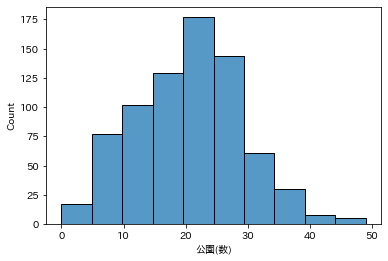

In [ ]:
sns.histplot(df_tokyo_district_master['公園(数)'], bins=10)
plt.show()

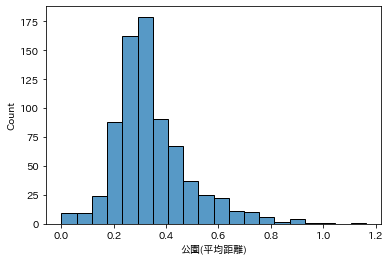

In [ ]:
sns.histplot(df_tokyo_district_master['公園(平均距離)'], bins=20)
plt.show()

In [ ]:
def normalize_score(sr_data, high=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    high = score.quantile(0.99)
    low = score.quantile(0.01)
    score[score > high] = high
    score[score < low] = low
    
    return (score - low)/(high - low)

def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

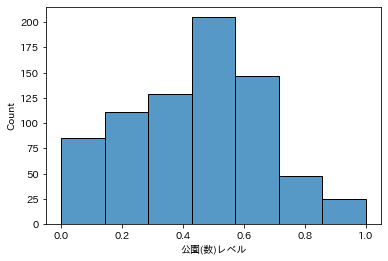

In [ ]:
df_tokyo_district_master['公園(数)レベル'] = normalize_score(df_tokyo_district_master['公園(数)'])
sns.histplot(df_tokyo_district_master['公園(数)レベル'], bins=7)
plt.show()

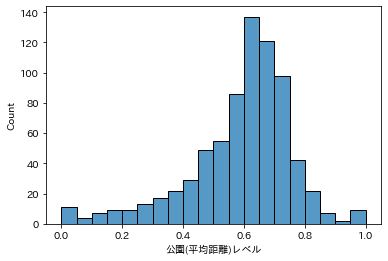

In [ ]:
df_tokyo_district_master['公園(平均距離)レベル'] = normalize_score(df_tokyo_district_master['公園(平均距離)'], False)
sns.histplot(df_tokyo_district_master['公園(平均距離)レベル'], bins=20)
plt.show()

In [ ]:
score_list = [
    df_tokyo_district_master['公園(平均距離)レベル'] * 0.5,
    df_tokyo_district_master['公園(数)レベル'] * 0.5,
]
df_tokyo_district_master['_公園スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False))
df_tokyo_district_master['公園スコア'] = rank_score(df_tokyo_district_master['_公園スコア'])

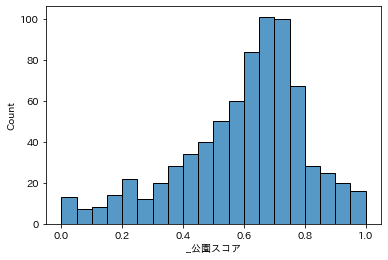

In [ ]:
sns.histplot(df_tokyo_district_master['_公園スコア'], bins=20)
plt.show()

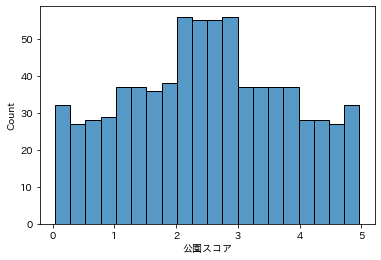

In [ ]:
sns.histplot(df_tokyo_district_master['公園スコア'], bins=20)
plt.show()

### 公園スコア出力

In [ ]:
df_tokyo_district_master[['市区町村名', '町丁目', '公園(平均距離)', '公園(数)', '公園スコア']].to_csv(os.path.join(DIR_NAME, 'park_score.csv'), index=False)

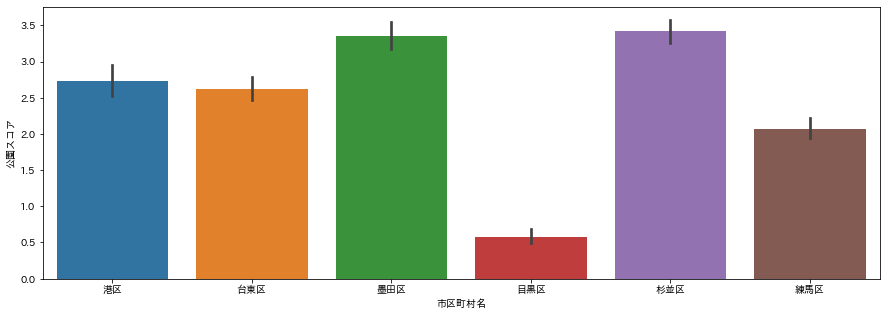

In [ ]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y='公園スコア', data=df_tokyo_district_master)
plt.show()

In [ ]:
df_park_level = df_tokyo_district_master.copy()
df_park_level['rank'] = df_park_level.groupby('町名')['公園スコア'].transform('rank', ascending=False)
df_park_level = df_park_level[df_park_level['rank'] == 1].sort_values('公園スコア', ascending=False)[
    ['市区町村名', '町名', '町丁目', '公園スコア', '_公園スコア', '公園(平均距離)', '公園(数)']
].reset_index(drop=True)
print(df_park_level.shape)

(185, 7)


In [ ]:
df_park_level.head(20)

,市区町村名,町名,町丁目,公園スコア,_公園スコア,公園(平均距離),公園(数)
0,墨田区,京島,京島１丁目,4.968847,1.000000,0.166566,40
1,杉並区,高井戸東,高井戸東４丁目,4.928794,0.998741,0.191452,40
2,墨田区,墨田,墨田１丁目,4.910992,0.976100,0.181000,38
3,杉並区,宮前,宮前２丁目,4.893191,0.966774,0.194229,38
4,杉並区,成田西,成田西３丁目,4.875389,0.962402,0.243002,40
5,練馬区,土支田,土支田３丁目,4.857588,0.949245,0.091385,32
6,杉並区,高井戸西,高井戸西２丁目,4.786382,0.920384,0.217466,36
7,港区,白金,白金１丁目,4.777481,0.916099,0.138405,32
8,練馬区,大泉町,大泉町２丁目,4.750779,0.914793,0.182827,34
9,杉並区,成田東,成田東３丁目,4.732977,0.910872,0.209674,35


In [ ]:
df_park_level.tail(20)

,市区町村名,町名,町丁目,公園スコア,_公園スコア,公園(平均距離),公園(数)
165,目黒区,下目黒,下目黒４丁目,0.907877,0.368348,0.489721,12
166,目黒区,大橋,大橋１丁目,0.774366,0.334351,0.388953,5
167,目黒区,東が丘,東が丘２丁目,0.747664,0.323205,0.404764,5
168,目黒区,東山,東山３丁目,0.738763,0.320119,0.409142,5
169,目黒区,八雲,八雲５丁目,0.729862,0.319586,0.452467,7
170,目黒区,青葉台,青葉台３丁目,0.694259,0.301567,0.435458,5
171,目黒区,南,南２丁目,0.676457,0.298738,0.482042,7
172,目黒区,碑文谷,碑文谷２丁目,0.667557,0.293504,0.489467,7
173,港区,台場,台場２丁目,0.649755,0.289157,0.559488,10
174,目黒区,鷹番,鷹番１丁目,0.623053,0.276562,0.513499,7
